In [1]:
import pandas as pd
import numpy as np
import math

import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble

from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve, auc
from sklearn.utils import shuffle

from collections import Counter

from imblearn.over_sampling import RandomOverSampler

from scipy import stats, interp

import time

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

# How to decrease infant mortality?
Author: Nadine Ruecker.<br>


## Introduction

In my capstone analysis, I will describe the factors, that are most predictive of an increase or decrease in infant mortality. The results could be used in order to give countries with high infant mortality rates, a rank list of where to invest first in order to decrease the infant mortality rate as fast as possible.<br>
<br>
Infant mortality rate describes how many children die within their first year of life per 1000 life birth. In 2016 the infant mortality in the United States of America was 5.6, the country with the lowest infant mortality was Iceland (1.6) and the country with the highest was Sierra Leone (83.3) (Source:http://www.who.int/gho/child_health/mortality/neonatal_infant_text/en/). Globally, infant mortality rates are decreasing. But still 4.2 million children died in 2016, before their first birthday.<br>

<br>
## Analysis summary<br>
My starting point was the global health statistic data from Kaggel, which provided a variety of different features from nutrition over education, population statistics and a few economic features annually recorded from 1960-2015 for over 260 countries. It was further combined with gross domestic product data from the UN (1948-2010) and other economic and political features. I further added location data (region, subregion…).<br>
<br>
Aiming to predict which features are most important to detect infant mortality rate increases/decreases in low income countries, I first excluded countries with gross national income per capita of more than $10,000.00, - and then calculated yearly differences of infant mortality rate for each country, which was then converted into a categorical feature (0 = decrease, 1 = increase).This raw dataset has 7777 rows and 359 features. The dataset was missing a lot of data (43.7%). I decided to average the data by subregion and year. Next, I removed columns that contained more than 60% nans and then removed all rows with any nans. This resulted in a much smaller dataset with data for 19 subregions from 1980 till 2009.
Next, I used correlation with the target to determine which features will be most predictive for my model. As the identity of the features is of relevance for my research question, I could not use feature reduction techniques like PCA. <br>
<br>
A lot of features are causally connected, e.g. growing economy results in good access to healthcare, which goes along with higher immunization rates. I decided to further explore the features by categories. Each feature is assigned into one of the following groups: Economics, Education, Infectious disease, Health care, Population. Maybe  one of those groups is more important than others. After calculating the mean absolute correlation coefficients for each feature class, the health care class seemed to be the most promising group, directly followed by the population class. Economics, education and infectious diseases gave very similar correlation results but had high standard deviations, indicating that they have very predictive features among less predictive ones. <br>
I explored collinearity for each group and decided per group which feature(s) to keep, after this process 11 features remained. Further, I explored the distribution of the features for instances with increases and decreases in infant mortality rates.  I removed a few extreme outliers for ‘GDP VOLUME % CHANGE’ and total population of 00-14 year old, the dataset shrunk to now 296 rows with 9 numeric features. T-tests demonstrate that each remaining features one its own was not very predictive (not significant between groups). This means that the differences between the feature groups are subtle. But I also only retained 42 instances of increased infant mortality rates, in 245 datapoints.
<br>
After scaling the numeric features and conversion of the categorical ‘subregion’ feature into binary data, I tested several classification models on a balanced (oversampled) dataset. Random forest classification (RFC) and gradient boosting with decision trees both resulted in scores around 0.80. I focused my further analysis on random forest. The RFC gives excellent sensitivity, but lacks on specificity (only 60% accuracy). The most important feature for the modeling is total population of 0 to 14-year old people (‘SP.POP.0014.TO’). This is an absolute number, not percent of the total population, therefore it is very difficult to interpret. The median SP.POP.0014.TO in instances with increases in infant mortality is lower than in instances without (6.4.1. second set of graphs).
RFC accuracy is 93% which is already pretty good. The model achieves 100% sensitivity but only 64% specificity. Using only the top 5 predictive features, I tried to improve the specificity. Each feature alone, does not improve the specificity, but all five together, indeed raise the accuracy to 0.99%. <br>
<br>
## Results<br>
The most important feature is the total number of children (age 00-14 years). This feature can not easily be converted into an action item. The total number of children is lower in subregions with increases in child mortality (see comparison in section 6.4.1). This might indicate, that people postpone having kids because of their living conditions. During war, famine or other life threating condition people are less likely to start or grow their family. 
Apart from the most predictive feature, the next important features indicate potential action items: Secure economics growth ('GDP volume % change) and increase number of physicians('SH.MED.PHYS.ZS'). This will probably go along with a reduction in adult mortality ('SP.DYN.AMRT_mean') and higher immunization rates('INF_mean'). The sixth most important feature is public spending on education('SE.EXP.TOTL.GD.ZS'), investing in education is likely to decrease infant morality as well. Probably, education improves the chances of getting a job, which supports economic security of the individual to start a family. The second to sixth most important feature will vary their position if the code is rerun, so their importance should not be considered by their rank. Their error bars also overlap, indicating that they all are similarly important. <br>
Those top 6 features are followed by the feature for 'year' and the categorical subregion features. I think it is intresting that year is more important than subregion, this indicates that events are important as well. War and famine, caused through catastrophic weather for example might explain, the relation ship of infant mortality increases.

<br>
## Discussion
Probably there are better ways to handle the missing data, rather than merging by subregion. Merging by subregion smoothed out extreme effects. It also prevented me from including additional features like political system or war, famine and other temporary country specific features to the data. This analysis would certainly benefit, if it could be analyzed by country, so that more fetaures can be included (like weather, poltical system and war).<br>
The data might not be accurate, as the data relies on spotsamples from each country and is then extrapolated to the total population. This is aleady pretty inaccurate, but it is even more questionable how well the data can be gathered during war for example or when people migrate into different countries because of their poor living conditions. It is possible, that infant mortality seems to increase suddenly, even though a war just ended, just because suddenly the governmental procedure of gathering the data is intact again. Generally phrased, the data collection machinery is not independent from the effects that I'm interested in, which is a huge point of inaccuracy.<br>



# Load and merge datasets

In [2]:
# Adding health and nutrition data from kaggle 
#https://www.kaggle.com/theworldbank/health-nutrition-and-population-statistics
HN= pd.read_csv("data.csv")
print(HN.shape)

sHN = pd.melt(HN, id_vars=['Country Name', 'Country Code','Indicator Name','Indicator Code'])
sHN=sHN.rename(index=str, columns={"variable": "Year"})

# Transform from skinny into wide format
cHN = sHN.pivot_table(index=['Country Name','Year', 'Country Code'], columns=['Indicator Code'],values='value').reset_index().rename_axis(None, axis=1)
cHN['Year']=cHN['Year'].apply(int)
cHN['Country Name']= cHN['Country Name'].str.lower()

print(cHN.shape)
cHN.head()

(89010, 60)
(14448, 348)


,Country Name,Year,Country Code,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,...,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT
0,afghanistan,1960,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8255331.0,1.511229,91.779,5.253807,739462.0,8.221,NaN
1,afghanistan,1961,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8385191.0,1.560800,91.492,5.305559,779754.0,8.508,NaN
2,afghanistan,1962,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8521053.0,1.607275,91.195,5.363622,822719.0,8.805,NaN
3,afghanistan,1963,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8663230.0,1.654771,90.890,5.395136,868325.0,9.110,NaN
4,afghanistan,1964,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8811623.0,1.698401,90.574,5.456539,917022.0,9.426,NaN


In [3]:
#Adding GDP data
GDP= pd.read_csv("UNdata_Export_20180728_185132879.csv")
# Transform from skinny into wide format
cGDP = GDP.pivot_table(index=['Country or Area','Year'], columns=['Description'],values='Value').reset_index().rename_axis(None, axis=1)
print(cGDP.shape)
cGDP = cGDP[['Country or Area','Year','GDP VOLUME % CHANGE', 'GROSS DOMESTIC PRODUCT']]
cGDP['Year']=cGDP['Year'].apply(int)
cGDP= cGDP.rename(index=str, columns={"Country or Area": "Country Name"})
cGDP['Country Name']= cGDP['Country Name'].str.lower()
print(cGDP.shape)
cGDP.head()

(11733, 261)
(11733, 4)


,Country Name,Year,GDP VOLUME % CHANGE,GROSS DOMESTIC PRODUCT
0,advanced economies,1968,NaN,NaN
1,advanced economies,1969,5.71050,NaN
2,advanced economies,1970,3.59522,NaN
3,advanced economies,1971,3.52803,NaN
4,advanced economies,1972,5.23774,NaN


In [4]:
# Country data
CD= pd.read_csv("country_centroids_az8.csv")
CD= CD[['name_long','economy','income_grp','continent','region_un','subregion','Longitude','Latitude']]
CD['name_long']= CD['name_long'].str.lower()
CD= CD.rename(index=str, columns={"name_long": "Country Name"})
print(CD['subregion'].unique())
print(len(CD['subregion'].unique()))
CD.head()

['Caribbean' 'Southern Asia' 'Middle Africa' 'Southern Europe'
 'Northern Europe' 'Western Asia' 'South America' 'Polynesia' 'Antarctica'
 'Australia and New Zealand' 'Seven seas (open ocean)' 'Western Europe'
 'Eastern Africa' 'Western Africa' 'Eastern Europe' 'Northern America'
 'Central America' 'South-Eastern Asia' 'Southern Africa' 'Eastern Asia'
 'Northern Africa' 'Melanesia' 'Micronesia' 'Central Asia']
24


,Country Name,economy,income_grp,continent,region_un,subregion,Longitude,Latitude
0,aruba,6. Developing region,2. High income: nonOECD,North America,Americas,Caribbean,-69.982677,12.520880
1,afghanistan,7. Least developed region,5. Low income,Asia,Asia,Southern Asia,66.004734,33.835231
2,angola,7. Least developed region,3. Upper middle income,Africa,Africa,Middle Africa,17.537368,-12.293361
3,anguilla,6. Developing region,3. Upper middle income,North America,Americas,Caribbean,-63.064989,18.223959
4,albania,6. Developing region,4. Lower middle income,Europe,Europe,Southern Europe,20.049834,41.142450


In [5]:
# Merge HN with GDP data by Country and Year
print(cHN.shape)
sdf = cHN.merge(cGDP, on=["Country Name","Year"], how='left')
print(sdf.shape)
# Add country data
sdf= sdf.merge(CD, on=["Country Name"],how='left')
print(sdf.shape)

(14448, 348)
(14448, 350)
(14448, 357)


In [6]:
# Plot Infant Mortality for the year 2016
Y2015=sdf[sdf['Year']==2015]
data = [ dict(
        type = 'choropleth',
        locations = Y2015['Country Code'],
        z = Y2015['SP.DYN.IMRT.IN'],
        text = Y2015['Country Code'],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Global Infant Mortality<br>per 1,000 life birth<br>2015'),
      ) ]

layout = dict(
    title = '2015 Global Infant Mortality Rates',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='d3-world-map' )

# Select data of interest
## Generate target feature

In [7]:
# make a new dataframe with binary target column
sdfClass = sdf
print(type(sdfClass))
print(sdfClass.shape)

<class 'pandas.core.frame.DataFrame'>
(14448, 357)


In [8]:
# Making sure that the data frame is sorted correctly
sdfClassSorted=sdfClass.sort_values(['Country Name','Year'], ascending=[True, True])

# Transform target into categorical
sdfClassSorted['INF_MORT_CHANGE_num'] =  sdfClassSorted['SP.DYN.IMRT.IN'].diff() # calculating the difference for each country to previous year
sdfClassSorted['INF_MORT_TREND'] = np.where(sdfClassSorted['INF_MORT_CHANGE_num']>0,'1','0') # INF_MORT_TREND 1= up, 0=down
print(sdfClassSorted.shape)

# how often did the INF_MORT increase?
print(sdfClassSorted['INF_MORT_TREND'].value_counts())
# this is prettty uneven, need to have an eye on that, probably oversample later on

(14448, 359)
0    13904
1      544
Name: INF_MORT_TREND, dtype: int64


## Remove high income countries

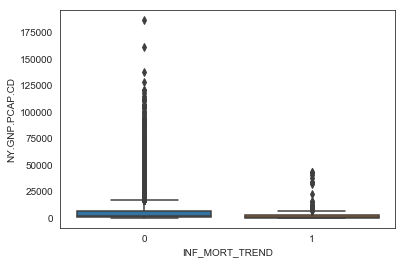

In [9]:
# I am particularly intrested in the features that contribute to decreases in infant mortality in low income countries.
# How does the GNI compare in countries that had an decrease/increase?
ax = sns.boxplot(y="NY.GNP.PCAP.CD", x="INF_MORT_TREND", data=sdfClassSorted)    
plt.show()

(14448, 359)
0    7464
1     313
Name: INF_MORT_TREND, dtype: int64
(7777, 359)


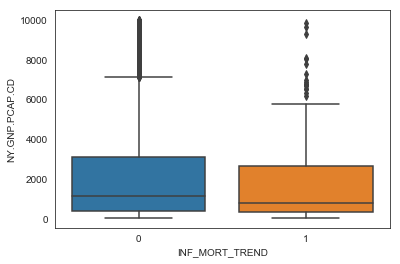

In [10]:
# Removingrich countries
print(sdfClassSorted.shape)
sdfnoRich= sdfClassSorted[(sdfClassSorted['NY.GNP.PCAP.CD']<10000)]
print(sdfnoRich['INF_MORT_TREND'].value_counts())
print(sdfnoRich.shape)
ax = sns.boxplot(y="NY.GNP.PCAP.CD", x="INF_MORT_TREND", data=sdfnoRich)    
plt.show()

# Remove Nas

In [11]:
# How many Nans are there?
print('Percent Nans:',(sdfnoRich.isnull().sum().sum()/(sdfnoRich.shape[0]*sdfnoRich.shape[1])*100), '%.')

Percent Nans: 43.75601507623902 %.


In [12]:
# Drop all rows that contain NAs
print(sdfnoRich.shape)
NoNas=sdfnoRich.dropna()
NoNas.shape

(7777, 359)


(0, 359)

In [13]:
# Okay each row contains Nas
# Then let's drop all columns that are na
NoNas= sdfnoRich.dropna(axis=1)
print(NoNas.shape)
NoNas.head()

# Nothing left either.

(7777, 6)


,Country Name,Year,Country Code,NY.GNP.PCAP.CD,SP.POP.TOTL,INF_MORT_TREND
44,afghanistan,2004,AFG,220.0,23499850.0,0
45,afghanistan,2005,AFG,250.0,24399948.0,0
46,afghanistan,2006,AFG,280.0,25183615.0,0
47,afghanistan,2007,AFG,340.0,25877544.0,0
48,afghanistan,2008,AFG,370.0,26528741.0,0


In [14]:
# Average the data by subregion to keep as much data as possible
# Mean of empty slice, occurs when nanmean is called on only Nas.
print(sdfnoRich.shape)
datan= sdfnoRich.set_index(['subregion','Year'])
data_num=datan._get_numeric_data()
data_num= data_num.reset_index()

print(data_num.shape)

# Loosing my target columns here and will have to recompute INF_MORT_TREND for subregion
subrdata=data_num.groupby(['subregion','Year']).aggregate(np.nanmean)
print(subrdata.shape)

(7777, 359)
(7777, 352)


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:1062: RuntimeWarning:

Mean of empty slice



(1008, 350)


In [15]:
# Recalculate INF_MORT_TREND for each subregion
# Making sure that the data frame is sorted correctly
subrdatasorted=subrdata.sort_values(['subregion','Year'], ascending=[True, True])

# Transform target into categorical
subrdatasorted['INF_MORT_CHANGE_num'] =  subrdatasorted.groupby(['subregion'])['SP.DYN.IMRT.IN'].diff()

print(subrdatasorted['INF_MORT_CHANGE_num'].head())
# calcualting the difference for each country to previous year
subrdatasorted['INF_MORT_TREND'] = np.where(subrdatasorted['INF_MORT_CHANGE_num']>0,'1','0') # INF_MORT_TREND 1= up, 0=down
print(subrdatasorted.shape)

# how often did the INF_MORT increase?
print(subrdatasorted['INF_MORT_TREND'].value_counts())
#this is still pretty uneven

subregion                  Year
Australia and New Zealand  1962    NaN
                           1963   -0.3
                           1964   -0.4
                           1965   -0.2
                           1966   -0.3
Name: INF_MORT_CHANGE_num, dtype: float64
(1008, 351)
0    917
1     91
Name: INF_MORT_TREND, dtype: int64


In [16]:
# Drop Columns that contain more than 40% Na
subrdataLess= subrdatasorted.dropna(thresh=subrdatasorted.shape[0]*0.60,axis=1) #thresh= that many none na values are required
subrdataLess=subrdataLess.reset_index()
print(subrdataLess.shape)

# Drop all remaining NA
subrnona=subrdataLess.dropna()
print(subrnona.shape)

# Check if variable of interest are still in the data set
print('INF_MORT_TREND' in subrnona.columns)

(1008, 196)
(323, 196)
True


In [17]:
# What is left
print('Number of subregions left:',len(subrnona['subregion'].unique()))
print("Subregions:",subrnona['subregion'].unique())
print(subrnona['Year'].min(), 'till',subrnona['Year'].max())

Number of subregions left: 19
Subregions: ['Caribbean' 'Central America' 'Central Asia' 'Eastern Africa'
 'Eastern Asia' 'Eastern Europe' 'Melanesia' 'Middle Africa'
 'Northern Africa' 'Northern Europe' 'Polynesia' 'South America'
 'South-Eastern Asia' 'Southern Africa' 'Southern Asia' 'Southern Europe'
 'Western Africa' 'Western Asia' 'Western Europe']
1980 till 2009


# Explore variables

In [18]:
# These are all the features
for i in subrnona.columns:
    print(i)
Features=pd.DataFrame(data={"Indicator Code":subrnona.columns.tolist()})
print(type(Features))

subregion
Year
NY.GNP.PCAP.CD
SE.PRM.CMPT.FE.ZS
SE.PRM.CMPT.MA.ZS
SE.PRM.CMPT.ZS
SE.PRM.ENRR
SE.PRM.ENRR.FE
SE.PRM.ENRR.MA
SE.PRM.NENR
SE.PRM.NENR.FE
SE.PRM.NENR.MA
SE.SEC.ENRR
SE.SEC.ENRR.FE
SE.SEC.ENRR.MA
SE.TER.ENRR
SE.TER.ENRR.FE
SE.XPD.TOTL.GD.ZS
SH.DTH.IMRT
SH.DTH.MORT
SH.DYN.MORT
SH.IMM.IBCG
SH.IMM.IDPT
SH.IMM.MEAS
SH.IMM.POL3
SH.MED.PHYS.ZS
SP.ADO.TFRT
SP.DYN.AMRT.FE
SP.DYN.AMRT.MA
SP.DYN.CBRT.IN
SP.DYN.CDRT.IN
SP.DYN.IMRT.IN
SP.DYN.LE00.FE.IN
SP.DYN.LE00.IN
SP.DYN.LE00.MA.IN
SP.DYN.TFRT.IN
SP.DYN.TO65.FE.ZS
SP.DYN.TO65.MA.ZS
SP.POP.0004.FE
SP.POP.0004.FE.5Y
SP.POP.0004.MA
SP.POP.0004.MA.5Y
SP.POP.0014.FE.IN
SP.POP.0014.FE.ZS
SP.POP.0014.MA.IN
SP.POP.0014.MA.ZS
SP.POP.0014.TO
SP.POP.0014.TO.ZS
SP.POP.0509.FE
SP.POP.0509.FE.5Y
SP.POP.0509.MA
SP.POP.0509.MA.5Y
SP.POP.1014.FE
SP.POP.1014.FE.5Y
SP.POP.1014.MA
SP.POP.1014.MA.5Y
SP.POP.1519.FE
SP.POP.1519.FE.5Y
SP.POP.1519.MA
SP.POP.1519.MA.5Y
SP.POP.1564.FE.IN
SP.POP.1564.FE.ZS
SP.POP.1564.MA.IN
SP.POP.1564.MA.ZS
SP.POP.1564.TO
SP.P

In [19]:
# Assign classes to the features
Definitions= pd.read_csv("Indicator classes.csv")

FeatureAnnotation=Features.merge(Definitions, on=["Indicator Code"])

# Count how many variables per class
FeatureAnnotation
print(FeatureAnnotation.groupby(['Class']).count())#aggregate(count)

for c in (FeatureAnnotation.Class.unique()):
    print(c)
    for f in FeatureAnnotation[FeatureAnnotation['Class']==c]['Indicator Name']:
        print(f)

       Indicator Code  Indicator Name
Class                                
ECO                 3               3
EDU                15              15
HC                  1               1
INF                 4               4
POP               167             167
ECO
GNI per capita, Atlas method (current US$)
Age dependency ratio (% of working-age population)
GDP VOLUME % CHANGE
EDU
Primary completion rate, female (% of relevant age group)
Primary completion rate, male (% of relevant age group)
Primary completion rate, total (% of relevant age group)
School enrollment, primary (% gross)
School enrollment, primary, female (% gross)
School enrollment, primary, male (% gross)
School enrollment, primary (% net)
School enrollment, primary, female (% net)
School enrollment, primary, male (% net)
School enrollment, secondary (% gross)
School enrollment, secondary, female (% gross)
School enrollment, secondary, male (% gross)
School enrollment, tertiary (% gross)
School enrollment, tertiary,

In [20]:
Definitions.head()

,Indicator Name,Indicator Code,Class
0,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,INF
1,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,INF
2,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,POP
3,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,INF
4,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,INF


In [21]:
# Add the class of the feature to each Indicator Code
FeatureAnnotation['Indi_Code_new']=FeatureAnnotation['Class']+"_"+FeatureAnnotation['Indicator Code']
print(FeatureAnnotation.head())
print(FeatureAnnotation.tail())

# Generate a list of new column names
newColnames=[]
for c in subrnona.columns:
    print(c)
    if c in FeatureAnnotation['Indicator Code']:
        newName= FeatureAnnotation['Indi_Code_new'][FeatureAnnotation['Indicator Code']==c].to_string()
        newColnames.append(newName)
        print(newName)
    else:
        oldName= FeatureAnnotation['Indicator Code'][FeatureAnnotation['Indicator Code']==c].to_string()
        newColnames.append(oldName)
        print(oldName)
print(newColnames)  

      Indicator Code                                     Indicator Name Class  \
0     NY.GNP.PCAP.CD         GNI per capita, Atlas method (current US$)   ECO   
1  SE.PRM.CMPT.FE.ZS  Primary completion rate, female (% of relevant...   EDU   
2  SE.PRM.CMPT.MA.ZS  Primary completion rate, male (% of relevant a...   EDU   
3     SE.PRM.CMPT.ZS  Primary completion rate, total (% of relevant ...   EDU   
4        SE.PRM.ENRR               School enrollment, primary (% gross)   EDU   

           Indi_Code_new  
0     ECO_NY.GNP.PCAP.CD  
1  EDU_SE.PRM.CMPT.FE.ZS  
2  EDU_SE.PRM.CMPT.MA.ZS  
3     EDU_SE.PRM.CMPT.ZS  
4        EDU_SE.PRM.ENRR  
          Indicator Code                            Indicator Name Class  \
185       SP.RUR.TOTL.ZS  Rural population (% of total population)   POP   
186          SP.URB.GROW        Urban population growth (annual %)   POP   
187          SP.URB.TOTL                          Urban population   POP   
188    SP.URB.TOTL.IN.ZS             Urban popu

# Feature reduction and exploration


## Correlation

In [22]:
# Chose numeric data
corrdat = subrnona._get_numeric_data()
print(corrdat.shape)
print( 'INF_MORT_TREND' in corrdat.columns)
#Add binary target back in
corrdat['INF_MORT_TREND']=pd.to_numeric(subrnona['INF_MORT_TREND'])
print(corrdat.shape)
print( 'INF_MORT_TREND' in corrdat.columns)

(323, 194)
False
(323, 195)
True


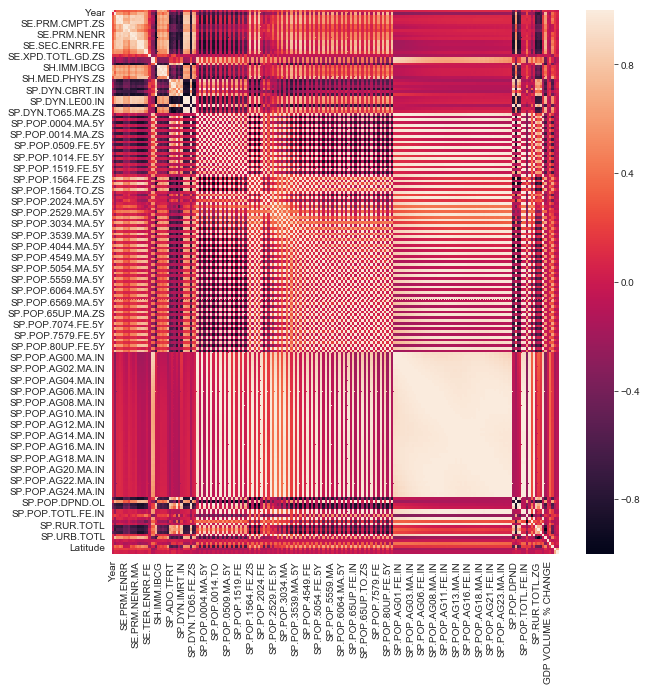

In [23]:
# See which features correlated with the target
CorrMa = corrdat.corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(CorrMa)#[['INF_MORT_TREND']])
plt.show()

In [24]:
# Rank the features by absolute corrlation coefficient
# Return the most positively and negatively correlated features 
CorrMa['abs_INF_MORT_TREND']=abs(CorrMa['INF_MORT_TREND'])
CorrMa=CorrMa.sort_values(by='abs_INF_MORT_TREND', ascending=False)
CorrMa['INF_MORT_TREND'].head()

INF_MORT_TREND         1.000000
INF_MORT_CHANGE_num    0.675519
SP.POP.AG00.FE.IN     -0.103345
SP.POP.AG01.FE.IN     -0.102552
SP.POP.0004.FE        -0.101880
Name: INF_MORT_TREND, dtype: float64

In [25]:
# Lots of equally correlated features, calculate mean correlation by class of features
CorrFeatdata=CorrMa[['INF_MORT_TREND','abs_INF_MORT_TREND']]
CorrFeatdata= CorrFeatdata.reset_index()
CorrFeatdata= CorrFeatdata.rename(index=str, columns={'index':'Indicator Code'})

FeatureClassCorr=CorrFeatdata.merge(Definitions, on=['Indicator Code'])

# group by Feature class and calculate mean correlation and std of absolute values correlation values
# to see which class is most important
MeanCorrdatabyClass=FeatureClassCorr.drop(['Indicator Name','Indicator Code','INF_MORT_TREND'], axis=1).groupby(['Class']).aggregate(np.mean)
StdCorrdatabyClass=FeatureClassCorr.drop(['Indicator Name','Indicator Code','INF_MORT_TREND'], axis=1).groupby(['Class']).aggregate(np.std)

### Correlation by feature class

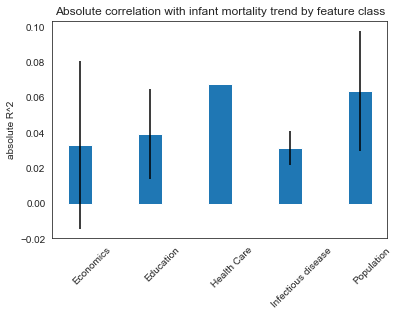

In [26]:
# Plot level of correlation for each feature class
fig, ax = plt.subplots()
ind = np.arange(5)  # the x locations for the groups
width = 0.35 

Means=MeanCorrdatabyClass.reset_index()['abs_INF_MORT_TREND']
Stds=StdCorrdatabyClass.reset_index()['abs_INF_MORT_TREND']

rects1 = ax.bar(ind, Means, width, yerr=Stds)

# add some text for labels, title and axes ticks
ax.set_ylabel('absolute R^2')
ax.set_title('Absolute correlation with infant mortality trend by feature class')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Economics', 'Education','Health Care',  'Infectious disease', 'Population'))
plt.xticks(rotation=45)
plt.show()

## Combine features for each class

In [27]:
# Subset the subregion data set into the different categories
# Melt all data except for 'subregion', 'year' and 'INF_MORT_TREND'
msr = pd.melt(subrnona, id_vars=['subregion', 'Year','INF_MORT_TREND'])
msr= msr.rename(index=str,columns={'variable':'Indicator Code'})

# Join the Class data
msr_class= msr.merge(Definitions, on=['Indicator Code'])

In [28]:
# Make new datasets
# function to subset the whole data set into data of the respective class

def subset_byClass(dataset,Class):
    print()
    print(Class)
    sdf= dataset[dataset['Class']==Class]
    print('skinny:',sdf.shape)
    df= sdf.pivot_table(index=['subregion','Year','INF_MORT_TREND'], columns=['Indicator Code'],values='value').reset_index()
    print('wide:',df.shape)
    return(df)

ECO=subset_byClass(msr_class,'ECO')
EDU=subset_byClass(msr_class,'EDU')
INF=subset_byClass(msr_class,'INF')
HC=subset_byClass(msr_class,'HC')
POP=subset_byClass(msr_class,'POP')


ECO
skinny: (969, 7)
wide: (323, 6)

EDU
skinny: (4845, 7)
wide: (323, 18)

INF
skinny: (1292, 7)
wide: (323, 7)

HC
skinny: (323, 7)
wide: (323, 4)

POP
skinny: (53941, 7)
wide: (323, 170)


### Ecomonics

In [29]:
# Make a correlation plot for each group and see which features can be combined
def make_corrplot(data,name):
    print(name)
    data['INF_MORT_TREND']=pd.to_numeric(data['INF_MORT_TREND'])
    cM= data.corr(method="pearson")
    plt.figure(figsize=(5,5))
    sns.heatmap(cM)
    plt.show()

ECO


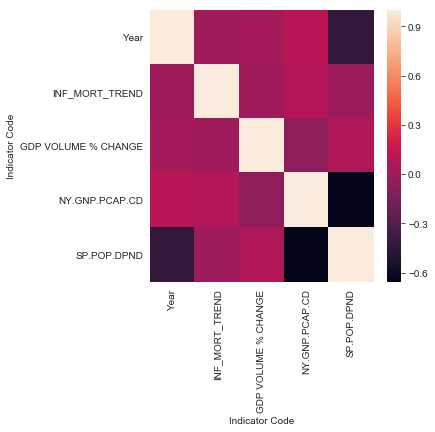

In [30]:
make_corrplot(ECO,'ECO')

For the ECO group I will remove NY.GNP.PCAP.CD (GNI,Gross national income per capita, Atlas method (current US$)),because it is strongly correlated with SP.POP.DPND (Age dependency ratio (% of working-age population). I will keep both remaining variables, because they represent two unrelated ecomonical aspects:<br>
GDP VOLUME % CHANGE: How much value did a country's economy produce compared to previous year<br>
SP.POP.DPND:Age dependency ratio (% of working-age population).

In [31]:
ECObf= ECO.drop('NY.GNP.PCAP.CD',axis=1)
ECObf.head()

Indicator Code,subregion,Year,INF_MORT_TREND,GDP VOLUME % CHANGE,SP.POP.DPND
0,Caribbean,1980,0,6.402986,72.038290
1,Caribbean,1984,0,2.162239,66.326639
2,Caribbean,1988,0,2.894840,65.027166
3,Caribbean,1990,0,1.727974,64.904791
4,Caribbean,1991,0,0.973159,64.319357


### Education

EDU


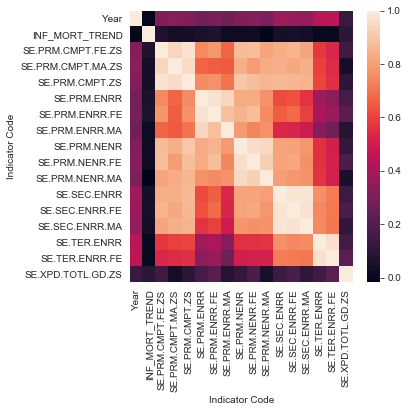

In [32]:
make_corrplot(EDU,'EDU')

There is lots of correlation in the education group. I will have to merge and exclude a lot of features. But which of those 16 features, correlates best with infant mortality trend?

In [33]:
CorrEDU= EDU.corr(method='pearson')
CorrEDU['abs_INF_MORT_TREND']=abs(CorrEDU['INF_MORT_TREND'])
CorrEDU=CorrEDU.sort_values(by='abs_INF_MORT_TREND', ascending=False)
print(CorrEDU['INF_MORT_TREND'])

Indicator Code
INF_MORT_TREND       1.000000
SE.XPD.TOTL.GD.ZS    0.096181
SE.PRM.CMPT.FE.ZS    0.068917
SE.PRM.ENRR.FE       0.062229
SE.PRM.ENRR          0.056835
SE.SEC.ENRR.FE       0.049549
SE.SEC.ENRR          0.045847
SE.PRM.CMPT.ZS       0.044174
SE.PRM.CMPT.MA.ZS    0.039440
SE.SEC.ENRR.MA       0.034312
SE.PRM.NENR.FE       0.024360
SE.PRM.NENR          0.020829
SE.PRM.ENRR.MA       0.018994
SE.PRM.NENR.MA      -0.017583
SE.TER.ENRR.FE       0.005687
SE.TER.ENRR          0.004111
Year                -0.002809
Name: INF_MORT_TREND, dtype: float64


The strongest features for education are:<br>
SE.XPD.TOTL.GD.ZS: Public spending on education, total (% of GDP) <br>
SE.PRM.CMPT.FE.ZS: Primary completion rate, female (% of relevant age group)<br>
<br>
Followed by different features of school enrollment split by school type (primary, secondary and tertiary).<br>
Those features correlate strongly with each other. Therefore, I will only keep, Public spending on education, and the genderless feature for primary school completion (SE.PRM.CMPT.ZS).

In [34]:
print(EDU.shape)
EDUbf= EDU[['INF_MORT_TREND','SE.PRM.CMPT.ZS', 'SE.XPD.TOTL.GD.ZS']]
print(EDUbf.shape)

(323, 18)
(323, 3)


EDU best features


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



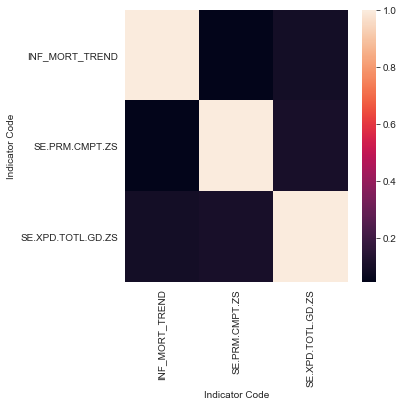

In [35]:
make_corrplot(EDUbf,'EDU best features')

### Infectious diseases

INF


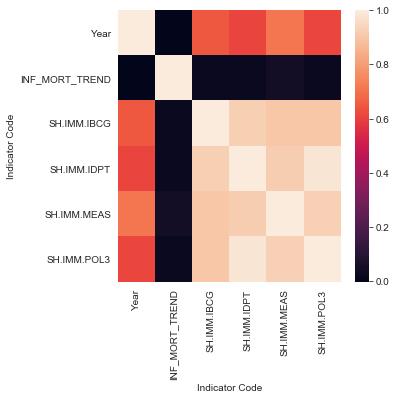

In [36]:
make_corrplot(INF, 'INF')

All features are immunization rates and they are all highly correlated with each other.<br>
SH.IMM.IBCG: Immunization, BCG (% of one-year-old children)<br>
SH.IMM.IDPT: Immunization, DPT (% of children ages 12-23 months) (diphtheria, pertussis and tetanus) <br>
SH.IMM.MEAS: Immunization, measles (% of children ages 12-23 months)<br>
SH.IMM.POL3: Immunization, Pol3 (% of one-year-old children)<br>
I will combine them into one combi feature.	

In [37]:
# Combine feaures for infectious diseases by averaging the immunization rates.
# The features don't have the same unit, so they need to be scaled
INFnew=INF[['SH.IMM.IDPT','SH.IMM.MEAS','SH.IMM.POL3','SH.IMM.IBCG']]
INFnew_sc=StandardScaler().fit_transform(INFnew.dropna())# calcualting z-scores
#bringing the data back into shape
INFnew_sc = pd.DataFrame(INFnew_sc, columns = INFnew.columns)
INFnew_sc= INFnew_sc.reset_index(drop=True)
INFnew['INF_mean'] = INFnew_sc.mean(axis=1)

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [38]:
print(INF.shape)
INFbf= INFnew['INF_mean']
print(INFbf.shape)

(323, 7)
(323,)


### Health Care

Health care


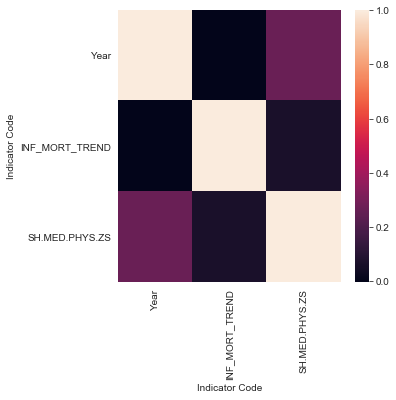

In [39]:
make_corrplot(HC,'Health care')

Health care only has one feature:<br>
SH.MED.PHYS.ZS: Physicians (per 1,000 people)<br>	

In [40]:
# This class has only one feature, I will keep it as is.
HCbf=HC.drop('INF_MORT_TREND', axis=1)

### Population

POP


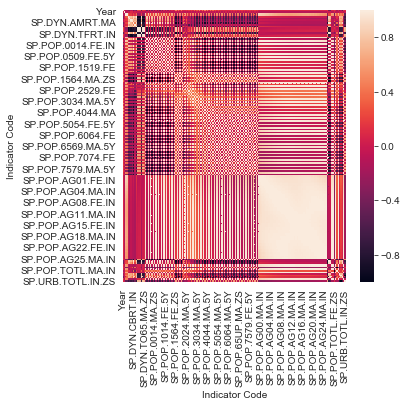

In [41]:
make_corrplot(POP,'POP')

In [42]:
print(POP.shape)

(323, 170)


The population class has 169 features. For this class I will chose the features again based on their correlation with the target.

In [43]:
CorrPop= POP.corr(method='pearson')
CorrPop['abs_INF_MORT_TREND']=abs(CorrPop['INF_MORT_TREND'])
CorrPop=CorrPop.sort_values(by='abs_INF_MORT_TREND', ascending=False)
print(CorrPop['INF_MORT_TREND'].head(20))

Indicator Code
INF_MORT_TREND       1.000000
SP.POP.AG00.FE.IN   -0.103345
SP.POP.AG01.FE.IN   -0.102552
SP.POP.0004.FE      -0.101880
SP.DYN.AMRT.MA       0.101547
SP.POP.AG02.FE.IN   -0.101477
SP.POP.AG00.MA.IN   -0.101217
SP.POP.AG01.MA.IN   -0.100410
SP.POP.AG03.FE.IN   -0.099834
SP.POP.0004.MA      -0.099824
SP.POP.AG02.MA.IN   -0.099364
SP.POP.AG03.MA.IN   -0.097912
SP.POP.AG04.FE.IN   -0.097794
SP.POP.0014.FE.IN   -0.096391
SP.POP.AG04.MA.IN   -0.096163
SP.POP.AG05.FE.IN   -0.096005
SP.POP.0014.TO      -0.095713
SP.DYN.AMRT.FE       0.095582
SP.POP.0014.MA.IN   -0.095087
SP.POP.AG05.MA.IN   -0.094568
Name: INF_MORT_TREND, dtype: float64


In [44]:
# selecting the population features with R^2 >0.095
popfeatures=CorrPop['INF_MORT_TREND'][CorrPop['abs_INF_MORT_TREND']>0.095]
print(popfeatures.shape)

(19,)


I chose the features with an R^2 of greater than .095. The following features remain:

In [45]:
popfeatures.index

Index(['INF_MORT_TREND', 'SP.POP.AG00.FE.IN', 'SP.POP.AG01.FE.IN',
       'SP.POP.0004.FE', 'SP.DYN.AMRT.MA', 'SP.POP.AG02.FE.IN',
       'SP.POP.AG00.MA.IN', 'SP.POP.AG01.MA.IN', 'SP.POP.AG03.FE.IN',
       'SP.POP.0004.MA', 'SP.POP.AG02.MA.IN', 'SP.POP.AG03.MA.IN',
       'SP.POP.AG04.FE.IN', 'SP.POP.0014.FE.IN', 'SP.POP.AG04.MA.IN',
       'SP.POP.AG05.FE.IN', 'SP.POP.0014.TO', 'SP.DYN.AMRT.FE',
       'SP.POP.0014.MA.IN'],
      dtype='object', name='Indicator Code')

POP_selected


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



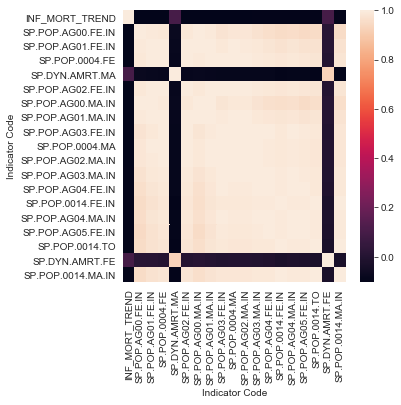

In [46]:
make_corrplot(POP[popfeatures.index],'POP_selected')

Mortality rates of men and women can be combined as total mortality:<br>
SP.DYN.AMRT.FE:Mortality rate, adult, female (per 1,000 female adults)<br>
SP.DYN.AMRT.MA:Mortality rate, adult, male (per 1,000 female adults)<br>
<br>
All other features are interpolated population fractions for children of certain ages; e.g. <br>
Age population, age 0, female, interpolated	SP.POP.AG00.FE.IN.<br>
I will keep a features that combines a broad range:<br>
SP.POP.0014.TO:Population ages 00-14, total. <br>
I will drop all other features.

In [47]:
# Chose to keep these features
POPbf=POP[['SP.POP.0014.TO']]
# Calculate means over gender by age group
POPbf['SP.DYN.AMRT_mean']=POP[['SP.DYN.AMRT.MA','SP.DYN.AMRT.FE']].mean(axis=1)

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Pop best features


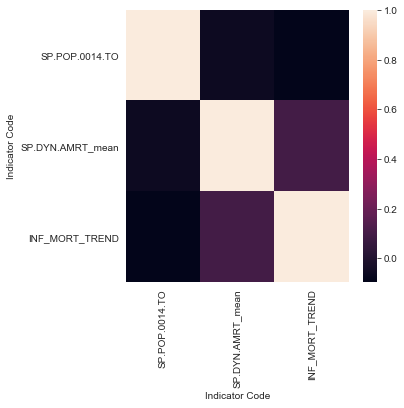

In [48]:
# Check correlaton of new features again
POPbf['INF_MORT_TREND']=POP['INF_MORT_TREND']
make_corrplot(POPbf, 'Pop best features')

Looks much better now.

## Explore best features

### Best feature correlation

In [49]:
# Combine data from section 5.3
bf = pd.concat([ECObf, EDUbf,INFbf,POPbf,HCbf], axis=1)
print(bf.shape)
# the target column was included in most dfs, remove those duplictaes columns
bf = bf.loc[:,~bf.columns.duplicated()]
print(bf.shape)
bf.head()

(323, 15)
(323, 11)


,subregion,Year,INF_MORT_TREND,GDP VOLUME % CHANGE,SP.POP.DPND,SE.PRM.CMPT.ZS,SE.XPD.TOTL.GD.ZS,INF_mean,SP.POP.0014.TO,SP.DYN.AMRT_mean,SH.MED.PHYS.ZS
0,Caribbean,1980,0,6.402986,72.038290,94.801548,6.068575,-1.603875,1.309974e+06,176.701083,0.726400
1,Caribbean,1984,0,2.162239,66.326639,94.478428,3.686200,-0.435572,1.101062e+06,172.532500,0.868700
2,Caribbean,1988,0,2.894840,65.027166,96.337555,3.940860,0.237627,9.486651e+05,172.490375,1.542433
3,Caribbean,1990,0,1.727974,64.904791,95.130672,4.216620,0.535837,9.450120e+05,167.376794,1.159938
4,Caribbean,1991,0,0.973159,64.319357,95.806582,6.043343,0.609924,9.456051e+05,171.125250,1.539475


Best features


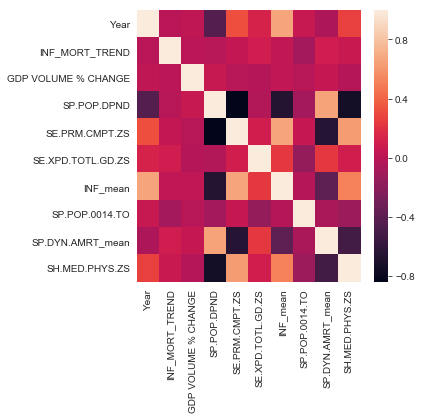

In [50]:
make_corrplot(bf, 'Best features')

SP.POP.DPND and SE.PRM.CMPT.ZS lead have strong correlation with several other features. I will drop those as well.

In [51]:
bf= bf.drop(['SP.POP.DPND','SE.PRM.CMPT.ZS'], axis=1)
print(bf.shape)

(323, 9)


Best features


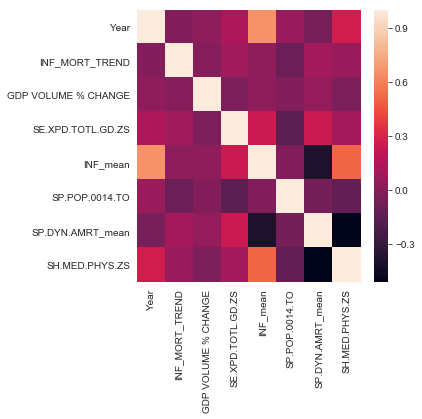

In [52]:
make_corrplot(bf, 'Best features')

### Explore feature relation to infant mortality

Ttest_indResult(statistic=0.034199059371303624, pvalue=0.9727396721952173)


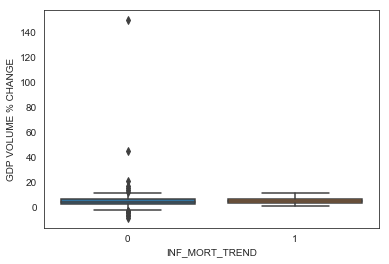

Ttest_indResult(statistic=1.7312427029423594, pvalue=0.08436932594400676)


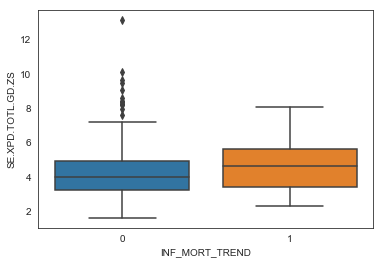

Ttest_indResult(statistic=0.5788802593161718, pvalue=0.5630759331103843)


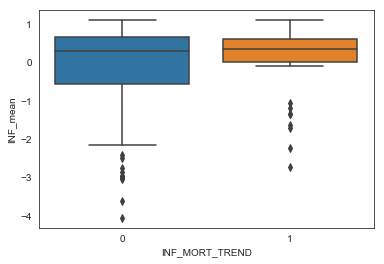

Ttest_indResult(statistic=-1.722743502771879, pvalue=0.08589802373489218)


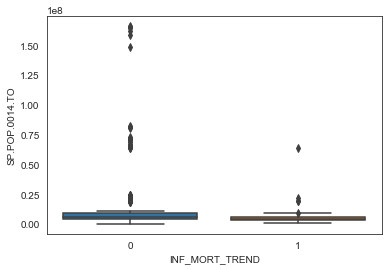

Ttest_indResult(statistic=1.803711753418877, pvalue=0.07221394409211043)


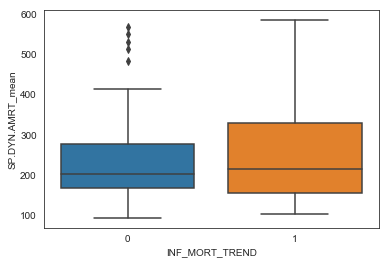

Ttest_indResult(statistic=1.212772104554157, pvalue=0.22610872094497836)


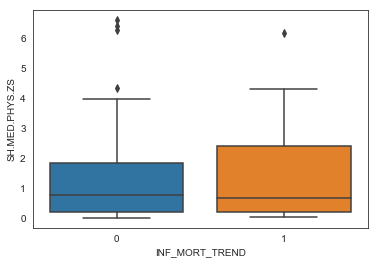

In [53]:
# Distributions of remaining features, by INF_MORT_TREND
ttest_results=[]
for f in bf.columns[3:9]:
    INF_M_UP=bf[f][bf['INF_MORT_TREND']==1]
    INF_M_DOWN=bf[f][bf['INF_MORT_TREND']==0]
    result=stats.ttest_ind(INF_M_UP,INF_M_DOWN)
    ttest_results.append(result)
    print(result)
    ax1 = sns.boxplot(y=f,x="INF_MORT_TREND", data=bf)
    plt.show()


In [54]:
# Removing only very high outliers
print(bf.shape)
# GDP VOLUME % change not higher than 20%
bfnoOut=bf[(bf['GDP VOLUME % CHANGE']<20) ]#& (bf['SP.POP.0014.TO']<0.3))]
# Population of 00-14 year olds
bfnoOut=bfnoOut[(bfnoOut['SP.POP.0014.TO']<(0.5*10**8))]
#bf= head
print(bfnoOut.shape)

(323, 9)
(296, 9)


Ttest_indResult(statistic=1.4435406295581872, pvalue=0.14993292375910441)


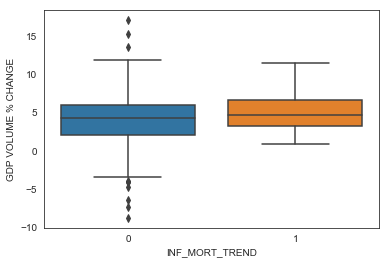

Ttest_indResult(statistic=1.446847931733971, pvalue=0.1490048547916347)


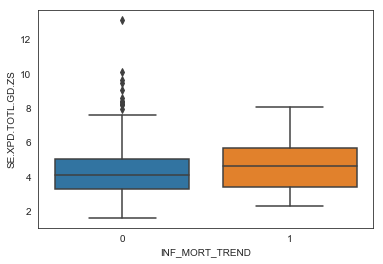

Ttest_indResult(statistic=0.3667128181222011, pvalue=0.714097027324086)


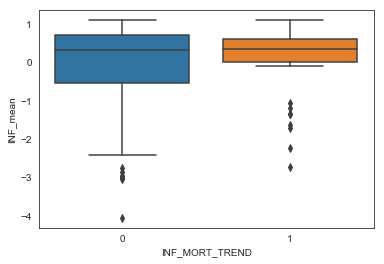

Ttest_indResult(statistic=-1.694959162901014, pvalue=0.09114198533844166)


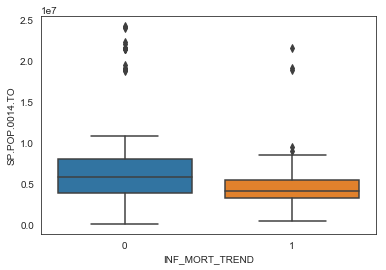

Ttest_indResult(statistic=1.8448894096010409, pvalue=0.06605931174025396)


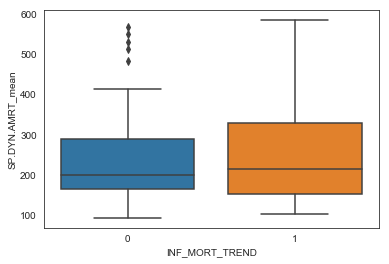

Ttest_indResult(statistic=0.9922496293043165, pvalue=0.321891703339222)


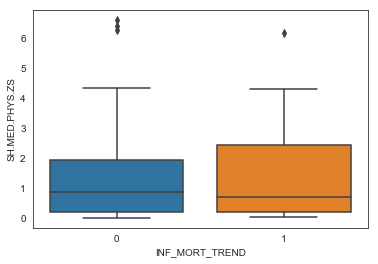

In [55]:
# New distributions after removing the outlier
ttest_results=[]
for f in bfnoOut.columns[3:9]:
    INF_M_UP=bfnoOut[f][bfnoOut['INF_MORT_TREND']==1]
    INF_M_DOWN=bfnoOut[f][bfnoOut['INF_MORT_TREND']==0]
    result=stats.ttest_ind(INF_M_UP,INF_M_DOWN)
    ttest_results.append(result)
    print(result)
    ax1 = sns.boxplot(y=f,x="INF_MORT_TREND", data=bfnoOut)
    plt.show()

In [56]:
# T-Test overview
ttestRes= pd.DataFrame(ttest_results)
ttestRes['Indicator Code']=bfnoOut.columns[3:9]
ttestRes=ttestRes.merge(Definitions, on=['Indicator Code'], how='left')
# Reorder columns
ttestRes= ttestRes[['Class','Indicator Name','Indicator Code','statistic','pvalue']]
ttestRes

,Class,Indicator Name,Indicator Code,statistic,pvalue
0,ECO,GDP VOLUME % CHANGE,GDP VOLUME % CHANGE,1.443541,0.149933
1,EDU,"Public spending on education, total (% of GDP)",SE.XPD.TOTL.GD.ZS,1.446848,0.149005
2,NaN,NaN,INF_mean,0.366713,0.714097
3,POP,"Population ages 00-14, total",SP.POP.0014.TO,-1.694959,0.091142
4,NaN,NaN,SP.DYN.AMRT_mean,1.844889,0.066059
5,HC,"Physicians (per 1,000 people)",SH.MED.PHYS.ZS,0.992250,0.321892


# Model

## Functions

In [57]:
# Function to predict increase or decrease in infant mortality with different models
# KNN, RFC, logit, Ridge, Lasso, Support vector machine and boosting model

In [58]:
def runRFC_class(input_df, target, no_folds):
    start_time=time.time()
    rand_forest_class = ensemble.RandomForestClassifier()
    rand_forest_class.fit(input_df, target)
    
    print('Feature Importance:{}',rand_forest_class.feature_importances_)
    cvs = cross_val_score(rand_forest_class, input_df, target, cv=no_folds)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [59]:
def runKNN_class(input_df, target,numNeigh, no_folds):
    start_time=time.time()
    knn_w = neighbors.KNeighborsClassifier(n_neighbors=numNeigh, weights='distance')
    cvs = cross_val_score(knn_w, input_df, target, cv=no_folds)
    
    # cross validation
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy KNN with weights: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [60]:
# Logistic regession
# Feature importance link:
#https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model
def runLogit(input_df,target,no_folds):
    start_time=time.time()

    logreg = linear_model.LogisticRegression(C=1e9)
    # Very high C=1e9 in order to barely get any l2 penalties
    logreg.fit(input_df, target)
    print('Coefficients Log Regression:',logreg.coef_)
      
    cvs = cross_val_score(logreg, input_df, target, cv=no_folds)

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [61]:
def runLogit_Ridge(input_df,target,lambd,no_folds):
    start_time=time.time()

    ridge = linear_model.Ridge(alpha = lambd)# C defaults to 1 => l2 penalties => Ridge
    ridge.fit(input_df, target)
    print('Coefficients Ridge Regression:',ridge.coef_)
      
    cvs = cross_val_score(ridge, input_df, target, cv=no_folds)

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [62]:
def runLogit_Lasso(input_df,target,lambd,no_folds):
    start_time=time.time()

    lasso = linear_model.Lasso(alpha = lambd)# C defaults to 1 => l2 penalties => Ridge
    lasso.fit(input_df, target)
    print('Coefficients Lasso Regression:',lasso.coef_)
      
    cvs = cross_val_score(lasso, input_df, target, cv=no_folds)

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [63]:
def runSVM(input_df,target,no_folds):
    start_time=time.time()
    svm = SVC(kernel = 'linear')   
    cvs=cross_val_score(svm,input_df, target, cv=no_folds)
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [64]:
def runBooster(input_df, target, no_folds):
    X = input_df
    y = target

    # Create training and test sets.
    offset = int(X.shape[0] * 0.6)
    print(offset)

    # Put 90% of the data in the training set.
    X_train, y_train = X[:offset], y[:offset] #from 0 : 7332

    # And put 10% in the test set.
    X_test, y_test = X[offset:], y[offset:] #from 7332 till the end

    # We'll make 500 iterations, use 3-deep trees, and set our loss function.
    params = {'n_estimators': 500,
              'max_depth': 3,
              'loss': 'deviance'}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    cvs=cross_val_score(clf,X,y, cv=no_folds)
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    return(cvs)

In [65]:
# Function to run all classifier models at once and plot scores
def predictINFMORT_TREND(input_df, target,numNeigh,lowestalpha, no_folds):

    print('Random Forest:')
    RFC = runRFC_class(input_df, target, no_folds)
    print()
    print('K-Nearest Neighbors:')
    KNN = runKNN_class(input_df, target,numNeigh, no_folds)
    print()
    print('Logistic Regression')
    Logit=runLogit(input_df,target,no_folds)
    print()
    print('Support Vector Maschine')
    SVM=runSVM(input_df,target,no_folds)
    print()
    print('Gradient Boost with Decision tree')
    Boost=runBooster(input_df, target, no_folds)
    
    lambd=lowestalpha
    
    print()
    print('Ridge Regression')
    Ridge_lamda = runLogit_Ridge(input_df, target,lambd, 10)
    Ridge_lamdax10 = runLogit_Ridge(input_df, target,lambd*10, 10)
    Ridge_lamdax100 = runLogit_Ridge(input_df, target,lambd*100, 10)
    Ridge_lamdax1000 = runLogit_Ridge(input_df, target,lambd*1000, 10)
    print()
    print('Lasso Regression')
    Lasso_lamda = runLogit_Lasso(input_df, target,lambd, 10)
    Lasso_lamdax10 = runLogit_Lasso(input_df, target,lambd*10, 10)
    Lasso_lamdax100 = runLogit_Lasso(input_df, target,lambd*100, 10)
    Lasso_lamdax1000 = runLogit_Lasso(input_df, target,lambd*1000, 10)
   
    Scores = {'RFC': RFC,'KNN':KNN, 'Logit':Logit,'SVM':SVM,'Booster':Boost, 'Ridge_L':Ridge_lamda,
             'Ridge_10xL':Ridge_lamdax10, 'Ridge_100xL':Ridge_lamdax100,
             'Ridge_1000xL':Ridge_lamdax1000,'Lasso_L':Lasso_lamda,
             'Lasso_10xL':Ridge_lamdax10, 'Lasso_100xL':Lasso_lamdax100,
             'Lasso_1000xL':Ridge_lamdax1000}
    Scoreresults = pd.DataFrame(data=Scores, index=(range(no_folds)))

    # Make a boxplot for comparison
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45)
    im.set_title('Scores of Classification Models')
    im.set_ylabel('Scores')
    im.set_xlabel('Models tried')

## Data preparation

In [66]:
# How many cases of increased infant mortality are included
print(bfnoOut.shape)
print(bfnoOut['INF_MORT_TREND'].tolist().count(1))
print(bfnoOut.dtypes)
bfnoOut.head()

(296, 9)
42
subregion               object
Year                     int64
INF_MORT_TREND           int64
GDP VOLUME % CHANGE    float64
SE.XPD.TOTL.GD.ZS      float64
INF_mean               float64
SP.POP.0014.TO         float64
SP.DYN.AMRT_mean       float64
SH.MED.PHYS.ZS         float64
dtype: object


,subregion,Year,INF_MORT_TREND,GDP VOLUME % CHANGE,SE.XPD.TOTL.GD.ZS,INF_mean,SP.POP.0014.TO,SP.DYN.AMRT_mean,SH.MED.PHYS.ZS
0,Caribbean,1980,0,6.402986,6.068575,-1.603875,1.309974e+06,176.701083,0.726400
1,Caribbean,1984,0,2.162239,3.686200,-0.435572,1.101062e+06,172.532500,0.868700
2,Caribbean,1988,0,2.894840,3.940860,0.237627,9.486651e+05,172.490375,1.542433
3,Caribbean,1990,0,1.727974,4.216620,0.535837,9.450120e+05,167.376794,1.159938
4,Caribbean,1991,0,0.973159,6.043343,0.609924,9.456051e+05,171.125250,1.539475


In [67]:
# Extract and scale numeric data
print(bfnoOut.shape)

numdata=bfnoOut.select_dtypes(include='number')
numdata = numdata.drop('INF_MORT_TREND', axis=1) # does not need to be scaled
print(numdata.shape)

# Some models need scaled data
bf_allNum_sc=StandardScaler().fit_transform(numdata.dropna())# calcualting z-scores
#bringing the data back into shape
bf_allNum_sc = pd.DataFrame(bf_allNum_sc, columns = numdata.columns)
bf_allNum_sc= bf_allNum_sc.reset_index(drop=True)
print(bf_allNum_sc.shape)
bf_allNum_sc.head()

(296, 9)
(296, 7)
(296, 7)


,Year,GDP VOLUME % CHANGE,SE.XPD.TOTL.GD.ZS,INF_mean,SP.POP.0014.TO,SP.DYN.AMRT_mean,SH.MED.PHYS.ZS
0,-1.909873,0.672133,1.068144,-1.714982,-1.005644,-0.550605,-0.440688
1,-1.426175,-0.620495,-0.448281,-0.487680,-1.047836,-0.592762,-0.329851
2,-0.942476,-0.397190,-0.286185,0.219515,-1.078614,-0.593188,0.194921
3,-0.700627,-0.752863,-0.110659,0.532784,-1.079351,-0.644902,-0.103005
4,-0.579703,-0.982940,1.052084,0.610612,-1.079232,-0.606994,0.192617


In [68]:
# For modeling covert subregion into a binary
bf_Cat= bfnoOut['subregion']
print(bf_Cat.shape)
bf_Catdum= pd.get_dummies(bf_Cat)
bf_Catdum['INF_MORT_TREND']=bfnoOut['INF_MORT_TREND']
print(bf_Catdum.shape)
bf_Catdum.head()

(296,)
(296, 18)


,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Europe,Melanesia,Middle Africa,Northern Africa,Northern Europe,Polynesia,South America,South-Eastern Asia,Southern Africa,Southern Europe,Western Africa,Western Asia,Western Europe,INF_MORT_TREND
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# combine cat. and num. data
bf_all= pd.concat([bf_Catdum.reset_index(drop=True),bf_allNum_sc], axis=1)
#df_c = pd.concat([df_a.reset_index(drop=True), df_b], axis=1)
print(bf_all.shape)

# How much infant mortality increase is left?
print(bf_all['INF_MORT_TREND'].value_counts())

# define data and target for classification
target_bin=bf_all['INF_MORT_TREND']
data_class=bf_all.drop(['INF_MORT_TREND'], axis=1)

# Balance data through oversampling
ros = RandomOverSampler(random_state=0)
print('Before oversampling',sorted(Counter(target_bin).items()))
X_resampled, y_resampled = ros.fit_sample(data_class, target_bin)
from collections import Counter
print('After oversampling',sorted(Counter(y_resampled).items()))

(296, 25)
0    254
1     42
Name: INF_MORT_TREND, dtype: int64
Before oversampling [(0, 254), (1, 42)]
After oversampling [(0, 254), (1, 254)]


Random Forest:
Feature Importance:{} [0.01169114 0.00446091 0.00464385 0.00976149 0.00563424 0.00605878
 0.00300127 0.00164068 0.00540942 0.00142191 0.00880842 0.0079059
 0.02339446 0.00764456 0.00432305 0.01398717 0.00092139 0.09291772
 0.11344496 0.12367906 0.14271697 0.18305228 0.14109118 0.08238919]
Time taken: 0.199 seconds.
Average accuracy RFC: 0.818
Standard deviation of accuracy: 0.146

K-Nearest Neighbors:
Time taken: 0.032 seconds.
Average accuracy KNN with weights: 0.692
Standard deviation of accuracy: 0.131

Logistic Regression
Coefficients Log Regression: [[ 0.47001091 -7.98664905 -9.31618836  4.13486164  1.06123304 -7.34125612
   1.44395374  3.48957698  0.01845263 -8.36326292  3.5933713  10.73580824
   5.31436707  0.28461784  3.98048422  2.49918485 -7.52661432 -0.1629997
   0.35604749 -0.33197039  0.130677   -2.51527703 -0.16275033  0.77129678]]
Time taken: 0.044 seconds.
Average accuracy: 0.485
Standard deviation of accuracy: 0.101

Support Vector Maschine
Time taken: 0

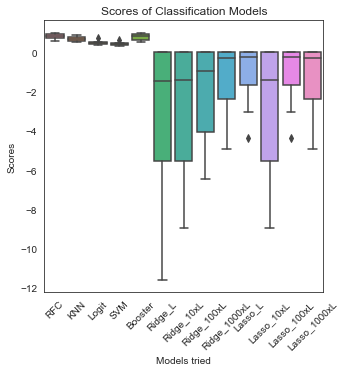

In [70]:
#predictINFMORT_TREND(input_df, target,numNeigh,lowestalpha, no_folds)
predictINFMORT_TREND(X_resampled, y_resampled,5,0.1,10)

In [71]:
# Function to run all classifier models at once and plot scores (no Ridge and Lasso scores plotted)
def predictINFMORT_TREND2(input_df, target,numNeigh,lowestalpha, no_folds):

    print('Random Forest:')
    RFC = runRFC_class(input_df, target, no_folds)
    print()
    print('K-Nearest Neighbors:')
    KNN = runKNN_class(input_df, target,numNeigh, no_folds)
    print()
    print('Logistic Regression')
    Logit=runLogit(input_df,target,no_folds)
    print()
    print('Support Vector Maschine')
    SVM=runSVM(input_df,target,no_folds)
    print()
    print('Gradient Boost with Decision tree')
    Boost=runBooster(input_df, target, no_folds)
    
    lambd=lowestalpha
    
    
    
   
    Scores = {'RFC': RFC,'KNN':KNN, 'Logit':Logit,'SVM':SVM,'Booster':Boost}
    Scoreresults = pd.DataFrame(data=Scores, index=(range(no_folds)))

    # Make a boxplot for comparison
    fig, ax = plt.subplots()
    fig.set_size_inches(5,5)
    im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45)
    im.set_title('Scores of Classification Models')
    im.set_ylabel('Scores')
    im.set_xlabel('Models tried')

Random Forest:
Feature Importance:{} [2.97516636e-03 1.69761128e-02 3.33352972e-03 4.73027551e-03
 3.34589521e-03 1.41961464e-03 2.29550794e-03 6.00536680e-03
 2.99643213e-03 1.11049653e-03 5.44783525e-03 7.40957558e-03
 1.90836469e-02 5.23921077e-03 1.56034921e-04 1.65767518e-02
 1.03695551e-03 7.43452325e-02 1.12450515e-01 1.30896216e-01
 1.51430928e-01 1.87759592e-01 1.32822709e-01 1.10156399e-01]
Time taken: 0.223 seconds.
Average accuracy RFC: 0.797
Standard deviation of accuracy: 0.142

K-Nearest Neighbors:
Time taken: 0.037 seconds.
Average accuracy KNN with weights: 0.692
Standard deviation of accuracy: 0.131

Logistic Regression
Coefficients Log Regression: [[ 0.47001091 -7.98664905 -9.31618836  4.13486164  1.06123304 -7.34125612
   1.44395374  3.48957698  0.01845263 -8.36326292  3.5933713  10.73580824
   5.31436707  0.28461784  3.98048422  2.49918485 -7.52661432 -0.1629997
   0.35604749 -0.33197039  0.130677   -2.51527703 -0.16275033  0.77129678]]
Time taken: 0.065 seconds.
A

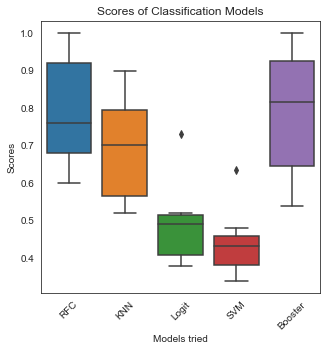

In [72]:
predictINFMORT_TREND2(X_resampled, y_resampled,5,0.1,10)

# Analysis of RFC

In [73]:
def CheckSenandSpe(Name,model,input_df,target,no_folds):
    y_pred = cross_val_predict(model,input_df,target,cv=no_folds)
    tn, fp, fn, tp = confusion_matrix(target,y_pred).ravel()
    
    print(Name)
    print()
    print('True Positives:',tp)
    print('False Negatives:',fn)
    
    Sensitivity=tp/(tp+fn)*100
    print('Sensitivity:',round(tp/(tp+fn)*100,3))
    print()
    print('True Negatives:',tn)
   
    print('False Positives:',fp)
    Specificity=tn/(tn+fp)*100
    print('Specificity:',round(tn/(tn+fp)*100))
    
    return(Sensitivity,Specificity)

In [74]:
rand_forest_class = ensemble.RandomForestClassifier()
CheckSenandSpe('RFC',rand_forest_class,X_resampled, y_resampled,10)

RFC

True Positives: 253
False Negatives: 1
Sensitivity: 99.606

True Negatives: 156
False Positives: 98
Specificity: 61.0


(99.60629921259843, 61.417322834645674)

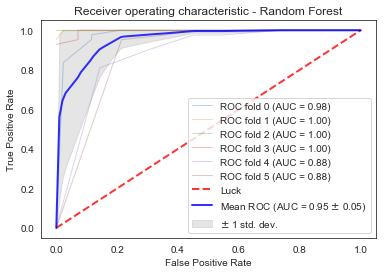

In [75]:
# Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
X = X_resampled
y = y_resampled
n_samples, n_features = X.shape

# Make it reproducible
random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves to get an idea of the standard deviation
cv = StratifiedKFold(n_splits=6)

rand_forest_class = ensemble.RandomForestClassifier()

# Crossvalidation to see the variance of the prediction
i = 0
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train, test in cv.split(X, y):
    classifier=rand_forest_class.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # Plot for each fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.legend()

# Calculate mean and std
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Most important features RFC

Random forest performs best with an average score of 0.80.

In [76]:
# Change runRFC so that it shows feature importance
def runRFCforFeatImp(input_df, target, no_folds):
    # Make it reproducible
    random_state = np.random.RandomState(1)
    
    start_time=time.time()
    rand_forest_class = ensemble.RandomForestClassifier()
    featImp=[]
    for i in range(no_folds):
        X_train, X_test, y_train, y_test = train_test_split(input_df, target, test_size=0.33, random_state=random_state)
        rand_forest_class.fit(X_train,  y_train)
        featImp.append(rand_forest_class.feature_importances_)
   
    return(featImp)

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

'.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.



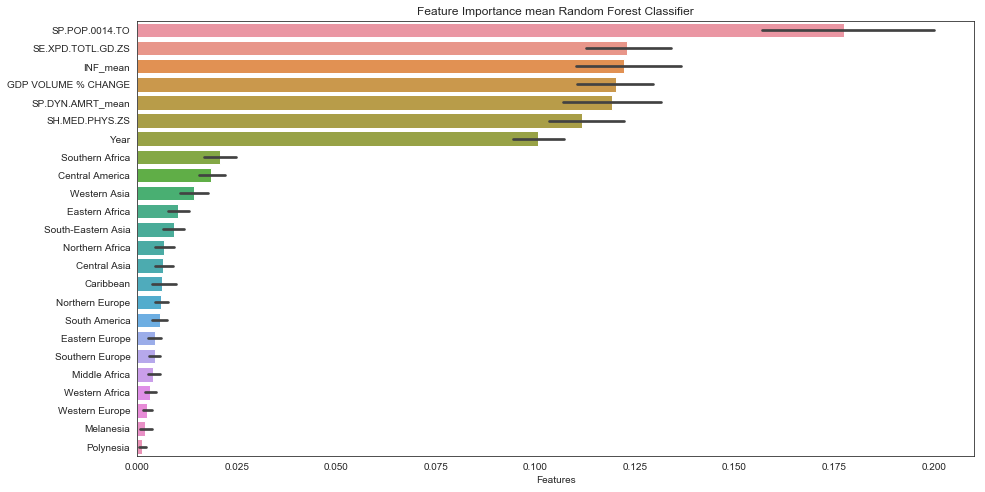

In [77]:
RFCImp = runRFCforFeatImp(X_resampled, y_resampled, 10)
df = pd.DataFrame(RFCImp, columns= data_class.columns)
# Sort columns by their mean values
df=df.reindex_axis(df.mean().sort_values(ascending=False).index, axis=1)

fig, ax = plt.subplots()
fig.set_size_inches(15,8)
im = sns.barplot(data=df[df.columns], ax=ax, orient='h')
#plt.setp(im.get_xticklabels(), rotation=45)
im.set_title('Feature Importance mean Random Forest Classifier')
im.set_xlabel('Features')
#fig.get_axes()[0].set_xscale('log')
plt.show()

# Optimize RFC

In [78]:
# define data and target for classification
target_bin=bf_all['INF_MORT_TREND']
# Select only the most predictive features
data_bf=bf_all[['SP.POP.0014.TO','GDP VOLUME % CHANGE','SH.MED.PHYS.ZS','SP.DYN.AMRT_mean','INF_mean','SE.XPD.TOTL.GD.ZS']]

# Balance data through oversampling
ros = RandomOverSampler(random_state=0)
print('Before oversampling',sorted(Counter(target_bin).items()))
X_resampled, y_resampled = ros.fit_sample(data_bf, target_bin)

print('After oversampling',sorted(Counter(y_resampled).items()))

Before oversampling [(0, 254), (1, 42)]
After oversampling [(0, 254), (1, 254)]


In [79]:
# Test all Features together
rand_forest_class = ensemble.RandomForestClassifier()
CheckSenandSpe('RFC',rand_forest_class,X_resampled,y_resampled ,10)

RFC

True Positives: 253
False Negatives: 1
Sensitivity: 99.606

True Negatives: 175
False Positives: 79
Specificity: 69.0


(99.60629921259843, 68.89763779527559)

In [80]:
# Accuracies when using only one feature
for c in range(len(data_bf.columns)):
    colName=data_bf.columns[c]
    print('Prediction with',colName,'only.')
    X=X_resampled[:,c].reshape(-1,1)
    CheckSenandSpe('RFC',rand_forest_class,X,y_resampled ,10)
    print()

Prediction with SP.POP.0014.TO only.
RFC

True Positives: 253
False Negatives: 1
Sensitivity: 99.606

True Negatives: 174
False Positives: 80
Specificity: 69.0

Prediction with GDP VOLUME % CHANGE only.
RFC

True Positives: 254
False Negatives: 0
Sensitivity: 100.0

True Negatives: 216
False Positives: 38
Specificity: 85.0

Prediction with SH.MED.PHYS.ZS only.
RFC

True Positives: 253
False Negatives: 1
Sensitivity: 99.606

True Negatives: 203
False Positives: 51
Specificity: 80.0

Prediction with SP.DYN.AMRT_mean only.
RFC

True Positives: 254
False Negatives: 0
Sensitivity: 100.0

True Negatives: 176
False Positives: 78
Specificity: 69.0

Prediction with INF_mean only.
RFC

True Positives: 253
False Negatives: 1
Sensitivity: 99.606

True Negatives: 210
False Positives: 44
Specificity: 83.0

Prediction with SE.XPD.TOTL.GD.ZS only.
RFC

True Positives: 253
False Negatives: 1
Sensitivity: 99.606

True Negatives: 204
False Positives: 50
Specificity: 80.0



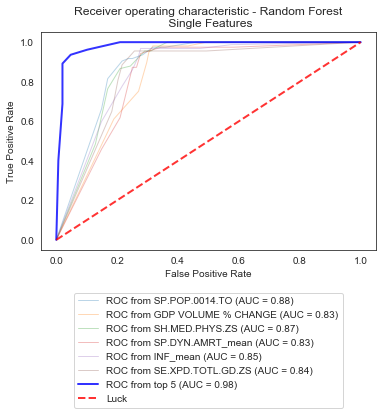

In [81]:
#for train, test in cv.split(X, y):
# Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
# Make it reproducible
random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves to get an idea of the standard deviation


rand_forest_class = ensemble.RandomForestClassifier()

# Crossvalidation to see the variance of the prediction

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


for c in range(len(data_bf.columns)):
    
    colName=data_bf.columns[c]

    X=X_resampled[:,c].reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.6, random_state=1)
    
    classifier=rand_forest_class.fit(X_train, y_train)
    probas_ = classifier.predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # Plot for each fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC from %s (AUC = %0.2f)' % (colName, roc_auc))

# Plot for all 5 features together
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.6, random_state=1)
colName='top 5'   
classifier=rand_forest_class.fit(X_train, y_train)
probas_ = classifier.predict_proba(X_test)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
# Plot for each separate feature
plt.plot(fpr, tpr, lw=2, alpha=0.8, color='b',
         label='ROC from %s (AUC = %0.2f)' % (colName, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Random Forest\n Single Features')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.75))

plt.show()